In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

import re

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 80)

 LendingClub DataSet from Kaggle: https://www.kaggle.com/wordsforthewise/lending-club

# Read data and info

In [2]:
data_info = pd.read_csv('./data/lending_club_info.csv')

In [3]:
data_info.head()

,LoanStatNew,Description
0,loan_amnt,The listed amount of the loan applied for by t...
1,term,The number of payments on the loan. Values are...
2,int_rate,Interest Rate on the loan
3,installment,The monthly payment owed by the borrower if th...
4,grade,LC assigned loan grade


In [4]:
def give_info(col):
    if isinstance(col, list):
        for c in col:
            print(c, data_info.loc[data_info['LoanStatNew'] == c, 'Description'].values, '\n')
    else:
        print(col, data_info.loc[data_info['LoanStatNew'] == col, 'Description'].values)

In [5]:
df = pd.read_csv('./data/lending_club_loan_two.csv')

In [6]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650"


In [7]:
give_info('emp_title')

emp_title ['The job title supplied by the Borrower when applying for the loan.*']


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

# Explore data and feature engineering

Check missing values

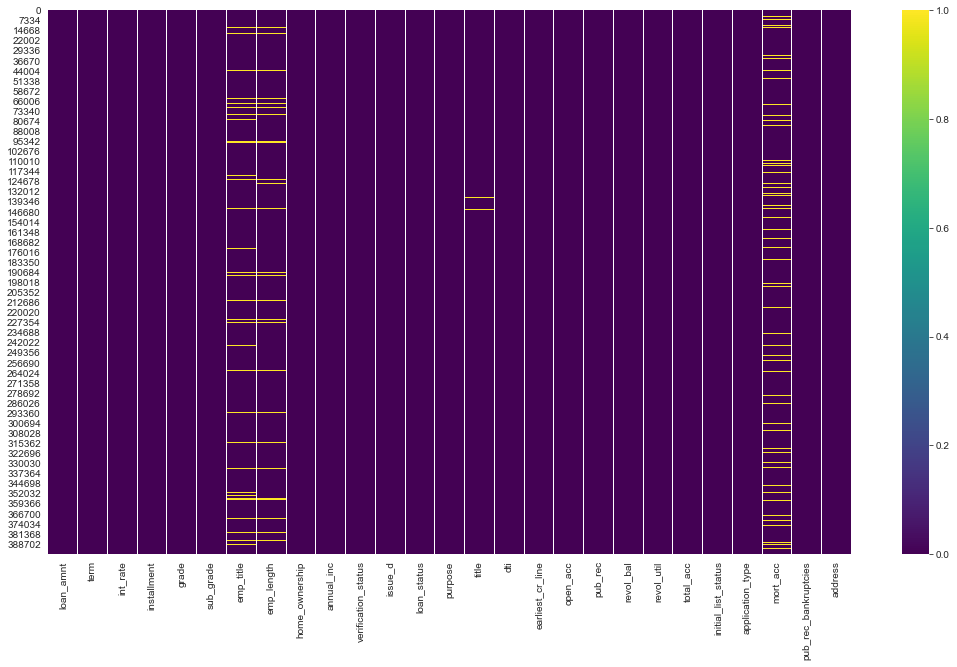

In [9]:
plt.figure(figsize=(18, 10))
sns.heatmap(df.isnull(), cmap='viridis')

In [10]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

## Convert the `term` column to a numerical one

In [11]:
df['term_num'] = df['term'].apply(lambda x: 60 if '60' in x else 36)

In [12]:
df.drop('term', axis=1, inplace=True)

## Drop `emp_title` col and `nan` in the `emp_length`

`emp_title` column is too complex to drive meaningful insight

In [13]:
len(df['emp_title'].unique())

173106

In [14]:
df.drop(columns=['emp_title'], inplace=True)

## Convert the emp_length to numeric

In [15]:
df['emp_length'].unique()

array(['10+ years', '4 years', '< 1 year', '6 years', '9 years',
       '2 years', '3 years', '8 years', '7 years', '5 years', '1 year',
       nan], dtype=object)

Check if there is any connection between the length of the employment and being charged off

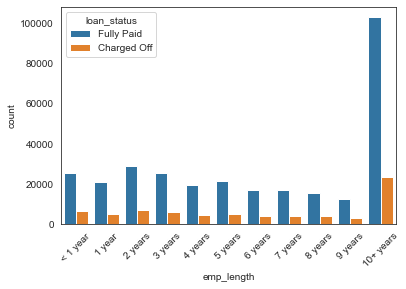

In [16]:
emp_length_order = ['< 1 year',
                    '1 year',
                    '2 years',
                    '3 years',
                    '4 years',
                    '5 years',
                    '6 years',
                    '7 years',
                    '8 years',
                    '9 years',
                    '10+ years']
sns.countplot(x='emp_length', data=df, order=emp_length_order, hue='loan_status')
plt.tick_params(axis='x', rotation=45)
plt.show()

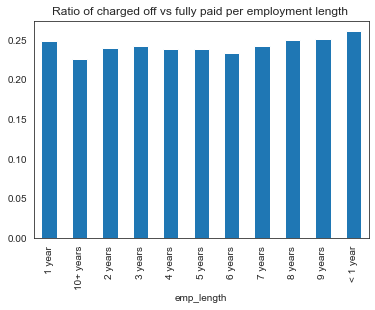

In [17]:
f1 = df[df['loan_status']=="Charged Off"].groupby("emp_length").count()['loan_status']
f2 = df[df['loan_status']=="Fully Paid"].groupby("emp_length").count()['loan_status']
(f1/f2).plot(kind='bar')
plt.title('Ratio of charged off vs fully paid per employment length ')
plt.show()


Not much variation depending on employment length as a proportion of the number, safe to drop the column

In [18]:
df.drop('emp_length', axis=1, inplace=True)

Convert the `emp_length` col into a numeric value if needed to be used and drop the `nan` values

In [19]:
# df = df[df['emp_length'].notna()]
# df['emp_length_num'] = df['emp_length'].apply(lambda x: int(re.findall(r'\d+', x)[0]))

## Extract the postcode from the address

In [20]:
df['address'].apply(lambda x: re.findall(r'.(\d{5})', x)[-1]).unique()

array(['22690', '05113', '00813', '11650', '30723', '70466', '29597',
       '48052', '86630', '93700'], dtype=object)

In [21]:
df['postcodes'] = df['address'].apply(lambda x: re.findall(r'.(\d{5})', x)[-1])

In [22]:
df.drop(columns=['address'], inplace=True)

## Drop `title`, `grade`, `issue_d`


`grade` info is covered by the `sub_grade` in more detail.

`issue_d` is not a valid feature, we shouldn't use the month the load was issued to train the model

In [23]:
give_info(['title', 'grade', 'sub_grade', 'issue_d'])

title ['The loan title provided by the borrower'] 

grade ['LC assigned loan grade'] 

sub_grade ['LC assigned loan subgrade'] 

issue_d ['The month which the loan was funded'] 



In [24]:
df.drop(columns=['title', 'grade', 'issue_d'], inplace=True)


## Group `home_ownership` into fewer categories

In [25]:
df['home_ownership'].value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: home_ownership, dtype: int64

In [26]:
df['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

## Make a numerical feature from the `earliest_cr_line`

In [27]:
give_info('earliest_cr_line')

earliest_cr_line ["The month the borrower's earliest reported credit line was opened"]


In [28]:
df['earliest_cr_line_year'] = df['earliest_cr_line'].apply(lambda x: int(x.split('-')[-1]))

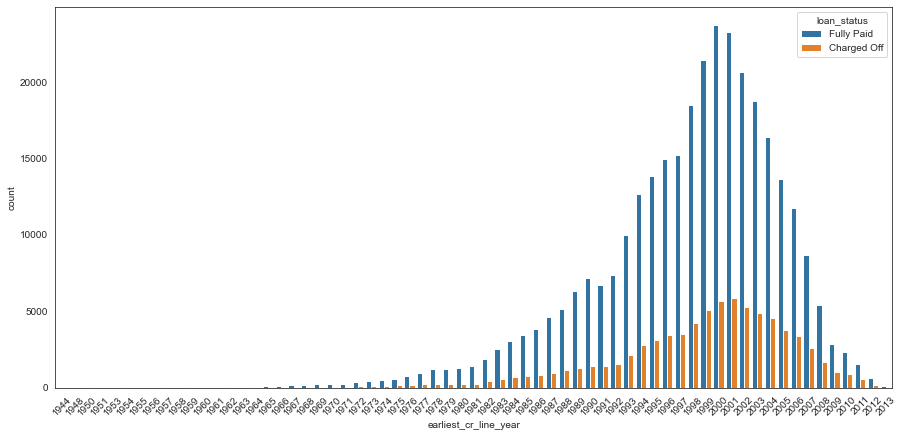

In [29]:
plt.figure(figsize=(15, 7))
sns.countplot(x='earliest_cr_line_year', data=df, hue='loan_status')
plt.tick_params(axis='x', rotation=45)
plt.show()

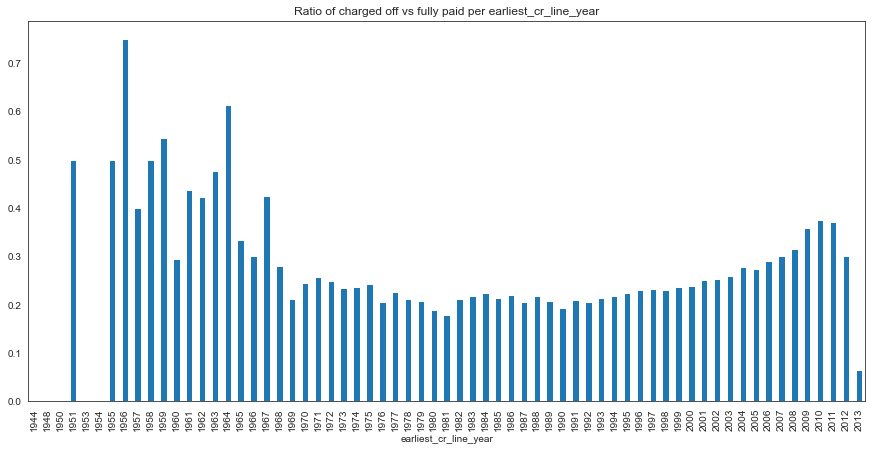

In [30]:
f1 = df[df['loan_status']=="Charged Off"].groupby("earliest_cr_line_year").count()['loan_status']
f2 = df[df['loan_status']=="Fully Paid"].groupby("earliest_cr_line_year").count()['loan_status']
plt.figure(figsize=(15, 7))
(f1/f2).plot(kind='bar')
plt.title('Ratio of charged off vs fully paid per earliest_cr_line_year')
plt.show()


A bit more variation in this feature that makes it worth keeping in the model

In [31]:
df.drop('earliest_cr_line', axis=1, inplace=True)

# Create dummy variables for the catigorical ones

In [32]:
df.columns

Index(['loan_amnt', 'int_rate', 'installment', 'sub_grade', 'home_ownership',
       'annual_inc', 'verification_status', 'loan_status', 'purpose', 'dti',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'term_num', 'postcodes',
       'earliest_cr_line_year'],
      dtype='object')

In [33]:
cols = ['verification_status', 'application_type',
        'initial_list_status', 'purpose',
        'sub_grade', 'home_ownership', 'postcodes']

df_final = pd.get_dummies(data=df, columns=cols, drop_first=True)

Drop `nan` values in the `revol_util` and `pub_rec_bankruptcies`

In [34]:
df_final = df_final[df_final['pub_rec_bankruptcies'].notna()]
df_final = df_final[df_final['revol_util'].notna()].reset_index(drop=True)

## Make the `loan_status` into a numerical one

In [35]:
df_final['loan_repaid'] = df_final['loan_status'].map({'Fully Paid':1,'Charged Off':0})

In [36]:
df_final.drop('loan_status', axis=1, inplace=True)

# Data Visualisations

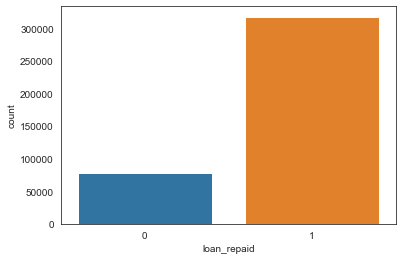

In [37]:
sns.countplot(df_final['loan_repaid'])

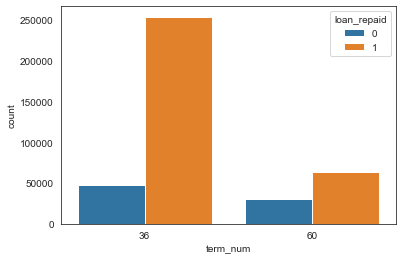

In [38]:
sns.countplot(df_final['term_num'], hue=df_final['loan_repaid'])

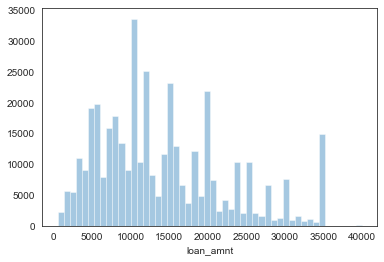

In [39]:
sns.distplot(df_final['loan_amnt'], kde=False)

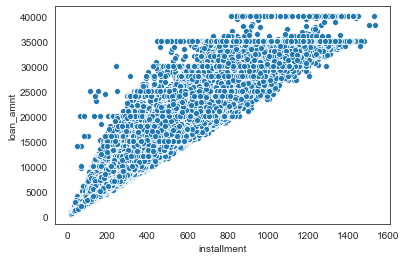

In [40]:
sns.scatterplot(x='installment',y='loan_amnt',data=df_final)
plt.show()

In [41]:
give_info('title'), give_info('purpose')

title ['The loan title provided by the borrower']
purpose ['A category provided by the borrower for the loan request. ']


(None, None)

# Fill missing values of `mort_acc`

In [42]:
give_info('mort_acc')

mort_acc ['Number of mortgage accounts.']


In [43]:
df['mort_acc'].isna().sum()

37795

In [44]:
values = df_final.drop('loan_repaid', axis=1).values

In [45]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [46]:
transformed_values = imputer.fit_transform(values)

In [47]:
foo = pd.DataFrame(transformed_values, columns=df_final.drop('loan_repaid', axis=1).columns)

In [48]:
foo.head()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,term_num,earliest_cr_line_year,verification_status_Source Verified,verification_status_Verified,application_type_INDIVIDUAL,application_type_JOINT,initial_list_status_w,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,postcodes_05113,postcodes_11650,postcodes_22690,postcodes_29597,postcodes_30723,postcodes_48052,postcodes_70466,postcodes_86630,postcodes_93700
0,10000.0,11.44,329.48,117000.0,26.24,16.0,0.0,36369.0,41.8,25.0,0.0,0.0,36.0,1990.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8000.0,11.99,265.68,65000.0,22.05,17.0,0.0,20131.0,53.3,27.0,3.0,0.0,36.0,2004.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15600.0,10.49,506.97,43057.0,12.79,13.0,0.0,11987.0,92.2,26.0,0.0,0.0,36.0,2007.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7200.0,6.49,220.65,54000.0,2.60,6.0,0.0,5472.0,21.5,13.0,0.0,0.0,36.0,2006.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24375.0,17.27,609.33,55000.0,33.95,13.0,0.0,24584.0,69.8,43.0,1.0,0.0,60.0,1999.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
df_final.head()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,term_num,earliest_cr_line_year,verification_status_Source Verified,verification_status_Verified,application_type_INDIVIDUAL,application_type_JOINT,initial_list_status_w,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,postcodes_05113,postcodes_11650,postcodes_22690,postcodes_29597,postcodes_30723,postcodes_48052,postcodes_70466,postcodes_86630,postcodes_93700,loan_repaid
0,10000.0,11.44,329.48,117000.0,26.24,16.0,0.0,36369.0,41.8,25.0,0.0,0.0,36,1990,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
1,8000.0,11.99,265.68,65000.0,22.05,17.0,0.0,20131.0,53.3,27.0,3.0,0.0,36,2004,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,15600.0,10.49,506.97,43057.0,12.79,13.0,0.0,11987.0,92.2,26.0,0.0,0.0,36,2007,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1
3,7200.0,6.49,220.65,54000.0,2.60,6.0,0.0,5472.0,21.5,13.0,0.0,0.0,36,2006,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,24375.0,17.27,609.33,55000.0,33.95,13.0,0.0,24584.0,69.8,43.0,1.0,0.0,60,1999,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


# Train the model

In [50]:
X = transformed_values
y = df_final['loan_repaid'].values

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [53]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
X.shape, y.shape

((395219, 78), (395219,))

In [55]:
model = Sequential()

# input layer
model.add(Dense(79,  activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [56]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [57]:
with tf.device("/device:GPU:0"):
    model.fit(x=X_train,
              y=y_train,
              epochs=600,
              batch_size=256,
              validation_data=(X_test, y_test),
              callbacks=[early_stop]
              )

Epoch 1/600
1158/1158 [==============================] - 2s 2ms/step - loss: 0.3016 - val_loss: 0.2633
Epoch 2/600
1158/1158 [==============================] - 2s 2ms/step - loss: 0.2665 - val_loss: 0.2610
Epoch 3/600
1158/1158 [==============================] - 2s 2ms/step - loss: 0.2634 - val_loss: 0.2601
Epoch 4/600
1158/1158 [==============================] - 2s 2ms/step - loss: 0.2624 - val_loss: 0.2600
Epoch 5/600
1158/1158 [==============================] - 2s 2ms/step - loss: 0.2615 - val_loss: 0.2594
Epoch 6/600
1158/1158 [==============================] - 2s 2ms/step - loss: 0.2609 - val_loss: 0.2589
Epoch 7/600
1158/1158 [==============================] - 2s 2ms/step - loss: 0.2603 - val_loss: 0.2590
Epoch 8/600
1158/1158 [==============================] - 2s 2ms/step - loss: 0.2599 - val_loss: 0.2588
Epoch 9/600
1158/1158 [==============================] - 2s 2ms/step - loss: 0.2599 - val_loss: 0.2589
Epoch 10/600
1158/1158 [==============================] - 2s 2ms/step - l

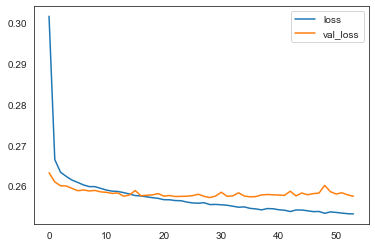

In [58]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

## Predict

Depreciation warning from `tf` when using `model.predict_classes(X_test)`

In [ ]:
# predictions = model.predict_classes(X_test)

In [59]:
pred = (model.predict(X_test) > 0.5).astype("int32")

In [60]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.94      0.46      0.62     19394
           1       0.88      0.99      0.93     79411

    accuracy                           0.89     98805
   macro avg       0.91      0.73      0.78     98805
weighted avg       0.89      0.89      0.87     98805



In [61]:
confusion_matrix(y_test,pred)

array([[ 8890, 10504],
       [  553, 78858]], dtype=int64)

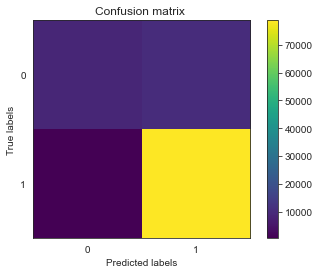

In [62]:
cm = confusion_matrix(y_test,pred)

plt.imshow(cm, cmap='viridis')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([0, 1], [0, 1])
plt.yticks([0, 1], [0, 1])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()
